# Load and define globals

In [3]:
import torch
from IPython.display import clear_output
import torchvision
import cv2
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image, ImageDraw, ImageFont
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 2**10 # 2**10

image_size = (100, 100, 3) # 100, 100, 3
embedding_size = 16 # 64

def to_img(x):
    return np.moveaxis(x.numpy() * 255, 0, -1).astype(np.uint8)

# Hyperparameters
image_size = (100, 100, 3)  # Dimensions of input images (height, width, channels)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(np.prod(image_size), 400)  # Input layer to hidden layer
        self.fc21 = nn.Linear(400, embedding_size)  # Hidden layer to mean of latent space
        self.fc22 = nn.Linear(400, embedding_size)  # Hidden layer to log variance of latent space
        self.fc3 = nn.Linear(embedding_size, 400)  # Latent space to hidden layer
        self.fc4 = nn.Linear(400, np.prod(image_size))  # Hidden layer to output layer

    # Encode function to obtain mean and log variance of the latent space
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    # Reparametrization trick to sample from the latent space
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()  # Compute standard deviation
        # Generate random noise
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)  # Return the sampled latent vector

    # Decode function to reconstruct the image from the latent vector
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # Forward pass through the VAE
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

def take_mean(df, accessions):
    df = pd.DataFrame(df)
    df['Accession'] = accessions
    df_grouped = df.groupby('Accession').mean()  # Automatically handles NaN with .mean()
    return df_grouped.reset_index(drop=True) # Reset index and drop the Accession column

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/Shareddrives/Strawberries/Image experiment/')

random_seed = 1

Mounted at /content/drive


In [6]:
model = VAE()
model.to(device)
model.load_state_dict(torch.load(str(random_seed) + "_vae_" + str(embedding_size) + ".pth", map_location=torch.device('cpu')))

<All keys matched successfully>

# Create image mosaic

In [7]:
images = torch.load('fullImages.pt')
trainKey = np.genfromtxt(f"{random_seed}_trainKey.csv", delimiter=',', skip_header=0)
testKey = np.genfromtxt(f"{random_seed}_testKey.csv", delimiter=',', skip_header=0)
accessions = trainKey.copy()
accessions[testKey >= 0] = testKey[testKey >= 0]
embeddings = []
for i in images:
  image = i.view(1, -1).to(device)  # Ensure image is on GPU and properly reshaped
  mu, logvar = model.encode(image)
  encoded = model.reparametrize(mu, logvar)
  embeddings.append(encoded.cpu().detach().numpy())
embeddings = np.array(embeddings).squeeze()
mean_embeddings = np.array(take_mean(embeddings, accessions))
rrBLUPPredictedEmbeddings = torch.tensor(pd.read_csv(str(random_seed) + '_rrBLUPpredictedEmbeddings_' + str(embedding_size) + '.csv').to_numpy(), dtype = torch.float32)

In [8]:
sampledImages = []
mosaics = []
encodedDecodedImages = []
encodedDecodedMosaics = []
meanEncodedDecodedImages = []
endToEndImages = []
for i in range(len(rrBLUPPredictedEmbeddings))[0:len(rrBLUPPredictedEmbeddings)]:
  theseImages = images[np.where(accessions == i)]
  sampledImages.append(to_img(theseImages[0]))

  num_images = len(theseImages)
  num_cols = int(np.ceil(np.sqrt(num_images)))
  num_rows = num_cols
  mosaic = np.zeros((num_rows * image_size[0], num_cols * image_size[1], image_size[2]), dtype=np.uint8)
  for j in range(num_images):
    row = j // num_cols
    col = j % num_cols
    mosaic[row * image_size[0]:(row + 1) * image_size[0], col * image_size[1]:(col + 1) * image_size[1], :] = to_img(theseImages[j])
  mosaic = cv2.resize(mosaic, (1000, 1000))
  mosaics.append(mosaic)

  theseEmbeddings = torch.tensor(embeddings[np.where(accessions == i)])
  encodedDecodedMosaic = np.zeros((num_rows * image_size[0], num_cols * image_size[1], image_size[2]), dtype=np.uint8)
  for j in range(num_images):
    row = j // num_cols
    col = j % num_cols
    decoded_image = model.decode(theseEmbeddings[j])
    decoded_image = decoded_image.view(1, -1)
    encodedDecodedMosaic[row * image_size[0]:(row + 1) * image_size[0], col * image_size[1]:(col + 1) * image_size[1], :] = to_img(decoded_image.detach().cpu().view(image_size[::-1]))
  encodedDecodedMosaic = cv2.resize(encodedDecodedMosaic, (1000, 1000))
  encodedDecodedMosaics.append(encodedDecodedMosaic)

  decoded_image = model.decode(theseEmbeddings[0])
  decoded_image = decoded_image.view(1, -1)
  decoded_image = to_img(decoded_image.detach().cpu().view(image_size[::-1]))
  decoded_image = cv2.resize(decoded_image, (1000, 1000))
  encodedDecodedImages.append(decoded_image)

  decoded_image = model.decode(torch.tensor(mean_embeddings[i]))
  decoded_image = decoded_image.view(1, -1)
  decoded_image = to_img(decoded_image.detach().cpu().view(image_size[::-1]))
  decoded_image = cv2.resize(decoded_image, (1000, 1000))
  meanEncodedDecodedImages.append(decoded_image)

  rrBLUPPredictedEmbedding = rrBLUPPredictedEmbeddings[i,:]
  decoded_image = model.decode(rrBLUPPredictedEmbedding.to(device))
  decoded_image = decoded_image.view(1, -1)
  decoded_image = to_img(decoded_image.cpu().detach().view(image_size[::-1]))
  decoded_image = cv2.resize(decoded_image, (1000, 1000))
  endToEndImages.append(decoded_image)

[ 22  26  36 471]


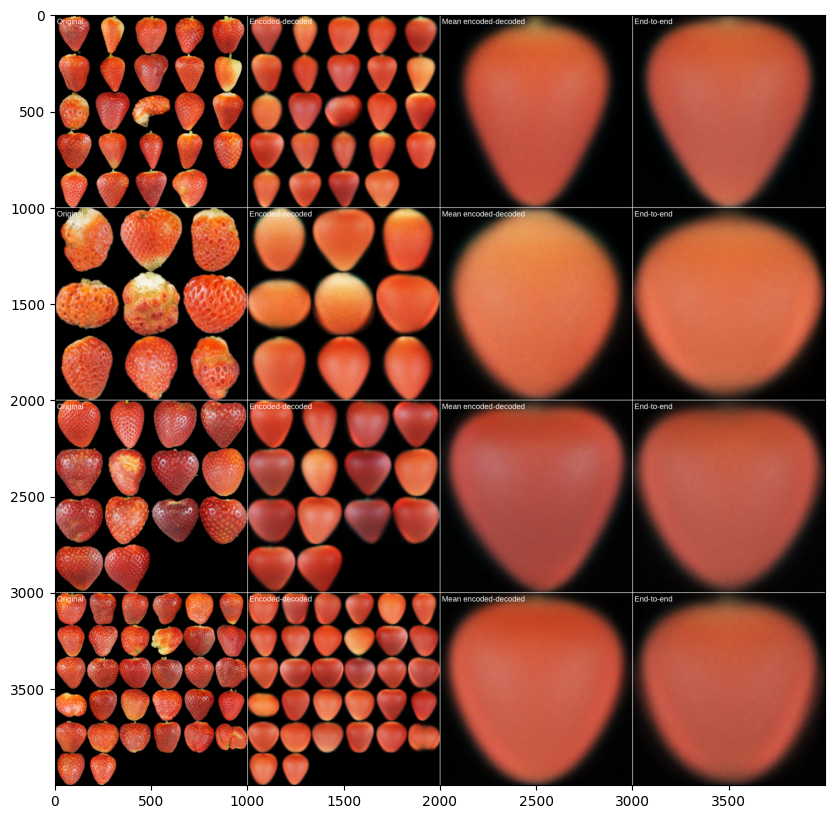

In [29]:
# which_genos = np.array(range(n_genotypes))

which_genos = np.array([i for i in set(testKey)]).astype(int)
# which_genos = which_genos[[9, 13, 15, 24]]
which_genos = which_genos[[9, 13, 15, 105]]
# which_genos = which_genos[[4, 6, 8, 16]]
# which_genos = which_genos[[0, 1, 2, 3]]

n_per_column_block = len(which_genos) # 50

column_blocks = []
for column_block in np.split(np.array(which_genos), (len(which_genos) // n_per_column_block)):
  print(column_block)
  fourColumnMosaics = []
  labels = ["Original", "Encoded-decoded", "Mean encoded-decoded", "End-to-end"]
  white = (255, 255, 255)

  # Load a TTF font
  font_path = '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf'  # Change for your OS
  font = ImageFont.truetype(font_path, size=40)

  for i in column_block:
      h, w, c = meanEncodedDecodedImages[i].shape
      row = np.zeros((h, 4 * w, c), dtype=np.uint8)

      # Fill in the 4 columns
      row[:, 0*w:1*w, :] = mosaics[i][:,:,::-1]
      row[:, 1*w:2*w, :] = encodedDecodedMosaics[i][:,:,::-1]
      row[:, 2*w:3*w, :] = meanEncodedDecodedImages[i][:,:,::-1]
      row[:, 3*w:4*w, :] = endToEndImages[i][:,:,::-1]

      # Add white vertical dividing lines between columns
      for j in range(1, 4):
          cv2.line(row, (j * w, 0), (j * w, h - 1), white, thickness=2)

      # Convert to PIL for text drawing
      row_pil = Image.fromarray(row)
      draw = ImageDraw.Draw(row_pil)

      # Draw the labels
      for j, label in enumerate(labels):
          text_pos = (j * w + 10, 10)  # y=10 is top of the image
          draw.text(text_pos, label, font=font, fill=white)

      # Back to NumPy
      row = np.array(row_pil)

      fourColumnMosaics.append(row)

  # Stack rows into one big image
  full_mosaic = np.vstack(fourColumnMosaics)

  # Add red horizontal lines between rows
  row_height = h
  for i in range(1, len(fourColumnMosaics)):
      y = i * row_height
      cv2.line(full_mosaic, (0, y), (full_mosaic.shape[1] - 1, y), white, thickness=2)

  column_blocks.append(full_mosaic)

  # break

# combine column blocks horizontally
full_mosaic = np.hstack(column_blocks)
# separate column blocks with vertical white lines
for i in range(1, len(column_blocks)):
  cv2.line(full_mosaic, (i * full_mosaic.shape[1] // len(column_blocks), 0), (i * full_mosaic.shape[1] // len(column_blocks), full_mosaic.shape[0] - 1), white, thickness=2)

cv2.imwrite("figures/prediction_results_mosaic_temp.png", full_mosaic[:,:,::-1])

plt.figure(figsize=(10, 10))
plt.imshow(full_mosaic)

# Plot correlations

In [ ]:
correlation_paths = [i for i in os.listdir() if 'correlations.csv' in i]
correlations = [pd.read_csv(i) for i in correlation_paths]

# group correlations by method and get np.corrcoef(correlations[i]['predicted'].values, correlations[i]['known'].values)[0,1]
for i in range(len(correlations)):
  correlations[i] = correlations[i].groupby('method').apply(lambda x: np.corrcoef(x['predicted'].values, x['known'].values)[0,1] ** 2, include_groups=False)
  correlations[i].reset_index()

# add seed and trait columns to correlations
for i in range(len(correlations)):
  correlations[i]['seed'] = correlation_paths[i].split('_')[0]
  correlations[i]['trait'] = correlation_paths[i].split('_')[1]

# return to row format
correlations = pd.concat(correlations, axis=1)

# transpose so it looks nicer
correlations = correlations.T

# convert end-to-end and traditional columns to long format, where the method column contains "end-to-end" or "traditional"
correlations = correlations.melt(id_vars=['seed', 'trait'], var_name='method', value_name='r2[predicted, known]')

In [ ]:
# group correlations by method and trait and get mean r2
correlations.drop(columns=['seed']).groupby(['method', 'trait']).mean().reset_index()

In [ ]:
# plot differences

# group correlations by seed and trait, and get difference between end-to-end and traditional prediction accuracies
correlation_differences = correlations.drop(columns=['method']).groupby(['seed', 'trait']).apply(lambda x: x.iloc[0] - x.iloc[1], include_groups=False).reset_index()

fig = px.box(correlation_differences, x="trait", y="r2[predicted, known]",
             title="Prediction Accuracy by Trait and Method",
             labels={"trait": "Trait", "r2[predicted, known] end-to-end - r2[predicted, known] conventional": "R2 Prediction Accuracy"},
             category_orders={"trait": ["LWR", "R", "G", "B", "Redness"]},
             boxmode="group")

# plot horizontal line at y = 1
fig = fig.add_shape(type='line', x0=-1, x1=5, y0=0, y1=0, line=dict(color='red', width=2))

fig.update_layout(
    yaxis=dict(range=[-1, 1]),
    yaxis_title="End-to-end r² - conventional genomic prediction r²",
    xaxis_title="Trait",
    legend_title="Prediction Method"
)

fig.show()